In [87]:
import torch

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'

In [103]:
from IPython.display import display
from PIL import Image

def show_img(input):
    img = Image.fromarray(input)

    display(img)

## Forward and Backward Diffusion: Adding and Removing Noise

![](./images/ddpm-diffusion-process.png)

### Forward (used at training time)

At every step of the process some noise is added to the image. Imagine we have a function `add_noise` that adds the noise at time $t$, we would have

```python
def forward(x,t=None):
        if t is None:
                t = timesteps
        
        x_t = x
        for tt in range(t)
                x_t = add_noise(x_t,tt)

        return x_t
```
In this specific case a Gaussian noise of mean $\sqrt{1 - \beta_t}$ and variance $\sqrt{\beta_t}$, so that
$$
x_t = \sqrt{1 - \beta_t} \cdot x_{t-1} + \sqrt{\beta_t} \cdot \epsilon, \qquad \epsilon \in \mathcal{N}(0,I)
$$
with
* $x_t$: noisy image at timestep $t$
* $\epsilon \sim \mathcal{N}(0, I)$: random Gaussian noise
* $\beta_t$: variance schedule — small values like 1e-4 → 0.02 across timesteps

but since the forward process is a **linear Gaussian chain** one can already precompute the total noise at time $t$, so one just need a function that computes the cumulative noise at time $t$ like





$$
x_t = \sqrt{\bar{\alpha}_t} \cdot x_0 + \sqrt{1 - \bar{\alpha}_t} \cdot \epsilon
$$

where $\bar{\alpha}_t$: cumulative product of $\alpha_t = 1 - \beta_t$


This is the **forward diffusion equation**. The code then becomes


```python
def forward(x,t=None):
        if t is None:
                t = timesteps

        x_t = add_noise_cum(x,t)
        return x_t
```



### Backward (used at inference time)

Removing noise, i.e. reconstructing the original image. Imagine we have a function `remove_noise_t` capable of removing noise added at time $t$, we would recover the initial image as

```python
def backward(x_noisy = None):
        x = x_noisy
        if x_noisy is None:
            # start from pure noise if no input is provided
            x = torch.randn(channels, img_size, img_size)

        for t in reversed(range(timesteps)):
            x = remove_noise_t(x, t)

        return x
```

However, it is easier to predict the noise itself (this has some theoretical grounds, but in practice it allows us to simplify the loss).

Imagine then we have a function `predict_noise_t` that predicts the noise at time $t$, the we denote by $\epsilon_\theta(x_t, t)$.

We reconstruct the previous image by sampling

$$
x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left(x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_\theta(x_t, t)\right) + \sigma_t z
$$

with $z \sim \mathcal{N}(0, I)$. Noise is resampled at each step (via $z$), not reused from prior steps.

In code this becomes

```python
def backward(x_noisy = None):
        x = x_noisy
        if x_noisy is None:
            # start from pure noise if no input is provided
            x = torch.randn(channels, img_size, img_size)

        for t in reversed(range(timesteps)):
            noise_pred = self._predict_noise(x, t)
            x = self._reconstruct_from_noise(x, t, noise_pred)

        return x
```



**Important** In here the term backward/forward should not be confused with the torch/backprop terminology. Here `backward` is used for prediction, so in the torch setting it is kind of a  torch forward, but not really since it is used only in prediction and not to compute the loss. On the other hand, `forward` is used in training (but it is NOT a backward in the autograd sense).

In [109]:
class DiffusionModel:

    def __init__(self,noise_pred_model, timesteps=300, start_beta = 1e-4, end_beta=0.02):

        self.noise_pred_model = noise_pred_model
        self.timesteps = timesteps
        self.betas =  torch.linspace(start_beta, end_beta, timesteps)
        self.alphas = 1.0 - self.betas
        self.alpha_hat = torch.cumprod(self.alphas, dim=0)

    # adds noise to an image
    def forward(self, image, t=None):
        if t is None:
            t = self.timesteps

        if isinstance(t, int):
            t = torch.tensor([t])

        sqrt_alpha_hat = self.alpha_hat[t].sqrt().view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_hat = (1 - self.alpha_hat[t]).sqrt().view(-1, 1, 1, 1)

        noise = torch.randn_like(image)

        return sqrt_alpha_hat * image + sqrt_one_minus_alpha_hat * noise, noise
    
    def predict_noise(self, x_t, t):
        return self.noise_pred_model(x_t,t)
    
    def _compute_mu_theta(self, x_t, t, noise_pred):
        """
        Compute the mean of the reverse process distribution p(x_{t-1} | x_t).

        Args:
            x_t: Noisy image at timestep t (B x C x H x W)
            t: Timestep tensor (B,)
            noise_pred: Predicted noise ε_θ(x_t, t) (B x C x H x W)

        Returns:
            mu_theta: The mean for the reverse step
        """
        alpha_t = self.alphas[t].view(-1, 1, 1, 1)
        alpha_hat_t = self.alpha_hat[t].view(-1, 1, 1, 1)
        one_minus_alpha_hat = 1. - alpha_hat_t

        mu_theta = (1. / alpha_t.sqrt()) * (x_t - ((1 - alpha_t) / one_minus_alpha_hat.sqrt()) * noise_pred)

        return mu_theta

    def _reconstruct_from_noise(self, x_t, t, noise_pred):
        x = self._compute_mu_theta(x_t, t, noise_pred)

        if t > 0:
            # add noise to the image, variance is not zero if t > 0
            noise = torch.randn_like(x)
            beta_t = self.betas[t].view(1, 1, 1, 1)
            x += beta_t.sqrt() * noise

        return x


    @torch.no_grad()
    def backward(self, batch_size=16, channels=3, img_size=32):
        x = torch.randn(batch_size, channels, img_size, img_size)

        for t in reversed(range(self.timesteps)):
            t_batch = torch.full((batch_size,), t, dtype=torch.long)

            noise_pred = self.predict_noise(x, t_batch)
            x = self._reconstruct_from_noise(x, t_batch, noise_pred)

        return x

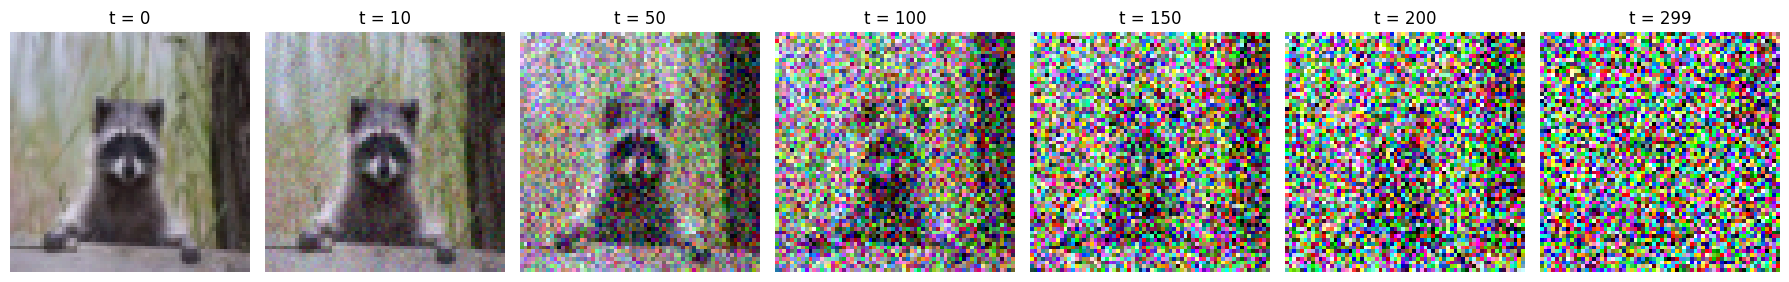

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T

image_path = 'data/racoon.jpg'
img = Image.open(image_path).convert('RGB')

transform = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor(),  # Converts to [0,1]
    T.Normalize(0.5,0.5) # Converts it to [-1,1]
])

inverse_transform = T.Compose([
    T.Lambda(lambda x: ((x + 1) / 2).clamp(0, 1)),
    T.ToPILImage(),
])

x0 = transform(img).unsqueeze(0)  # Shape: (1, 3, 64, 64)

# --- Initialize diffusion model
diffusion_model = DiffusionModel(None)

# --- Visualize noise at various steps
timesteps_to_plot = [0, 10, 50, 100, 150, 200, 299]  # Pick your own
noised_images = [diffusion.forward(x0, t)[0].squeeze(0) for t in timesteps_to_plot]

# --- Plot results
fig, axs = plt.subplots(1, len(timesteps_to_plot), figsize=(18, 4))

for i, (img, t) in enumerate(zip(noised_images, timesteps_to_plot)):
    img_np = inverse_transform(img)
    axs[i].imshow(img_np)
    axs[i].axis('off')
    axs[i].set_title(f't = {t}')

plt.tight_layout()
plt.show()


## Learning to denoise

Using a U-Net to predict the noise. Issue: we need to pass to it information about the amount of noise present in the image. In other words we need to find a way to insert the time step information into the U-Net. Timestep encoding to the rescue:


In [91]:
import torch.nn as nn
import math

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

![](./images/ddpm_unet.png)

In [92]:
class Block(nn.Module):
    def __init__(self, channels_in, channels_out, time_embedding_dims, labels, num_filters = 3, downsample=True):
        super().__init__()

        #############################
        self.time_embedding_dims = time_embedding_dims
        self.time_embedding = SinusoidalPositionEmbeddings(time_embedding_dims)
        #############################
        
        ############################
        # For later
        # self.labels = labels
        # if labels:
        #     self.label_mlp = nn.Linear(1, channels_out)
        ############################

        self.downsample = downsample

        if downsample:
            self.conv1 = nn.Conv2d(channels_in, channels_out, num_filters, padding=1)
            self.final = nn.Conv2d(channels_out, channels_out, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(2 * channels_in, channels_out, num_filters, padding=1)
            self.final = nn.ConvTranspose2d(channels_out, channels_out, 4, 2, 1)

        self.bnorm1 = nn.BatchNorm2d(channels_out)
        self.bnorm2 = nn.BatchNorm2d(channels_out)

        self.conv2 = nn.Conv2d(channels_out, channels_out, 3, padding=1)

        #############################
        self.time_mlp = nn.Linear(time_embedding_dims, channels_out)
        #############################

        self.relu = nn.ReLU()

    def forward(self, x, t, **kwargs):

        o = self.bnorm1(self.relu(self.conv1(x)))

        #######################
        o_time = self.relu(self.time_mlp(self.time_embedding(t)))
        o = o + o_time.unsqueeze(-1).unsqueeze(-1)
        #######################

        # if self.labels:
        #     label = kwargs.get('labels')
        #     o_label = self.relu(self.label_mlp(label))
        #     o = o + o_label.unsqueeze(-1).unsqueeze(-1)

        o = self.bnorm2(self.relu(self.conv2(o)))

        return self.final(o)

In [93]:
class UNet(nn.Module):
    def __init__(self, img_channels = 3, time_embedding_dims = 128, labels = False, sequence_channels = (64, 128, 256, 512, 1024)):
        super().__init__()
    
        self.time_embedding_dims = time_embedding_dims

        sequence_channels_rev = reversed(sequence_channels)

        self.downsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels) for channels_in, channels_out in zip(sequence_channels, sequence_channels[1:])])
        self.upsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels,downsample=False) for channels_in, channels_out in zip(sequence_channels[::-1], sequence_channels[::-1][1:])])
        self.conv1 = nn.Conv2d(img_channels, sequence_channels[0], 3, padding=1)
        self.conv2 = nn.Conv2d(sequence_channels[0], img_channels, 1)


    def forward(self, x, t, **kwargs):
        residuals = []
        o = self.conv1(x)
        for ds in self.downsampling:
            o = ds(o, t, **kwargs)
            residuals.append(o)
        for us, res in zip(self.upsampling, reversed(residuals)):
            o = us(torch.cat((o, res), dim=1), t, **kwargs)

        return self.conv2(o)

#### The training process

For every sample $x$ from the dataset, **select a random timestep $t$** and compute the $L^2$ distance between the added noise and the predicted one. In code

```python
noisy_image, noise = diffusion_model.forward(x,t)
pred_noise = diffusion_model._predict_noise(noisy_image,t)


loss = torch.nn.functional.mse_loss(noise,pred_noise)
```




In [98]:
NO_EPOCHS = 100
PRINT_FREQUENCY = 10
LR = 0.001
BATCH_SIZE = 1
VERBOSE = False

device = 'cpu'

unet = UNet(labels=False)
unet.to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

diffusion_model = DiffusionModel(unet)

In [ ]:
import numpy as np



for epoch in range(NO_EPOCHS):
    mean_epoch_loss = []

    batch = x0
    t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)

    batch_noisy, noise = diffusion_model.forward(batch, t)
    predicted_noise = diffusion_model.predict_noise(batch_noisy,t)

    optimizer.zero_grad()
    loss = torch.nn.functional.mse_loss(noise, predicted_noise)
    mean_epoch_loss.append(loss.item())
    loss.backward()
    optimizer.step()

    if epoch % PRINT_FREQUENCY == 0:
        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)}")

---
Epoch: 0 | Train Loss 1.0306618213653564
---
Epoch: 10 | Train Loss 0.5327253937721252
---
Epoch: 20 | Train Loss 0.5674975514411926
---
Epoch: 30 | Train Loss 0.3603355586528778
---
Epoch: 40 | Train Loss 0.15084852278232574
---
Epoch: 50 | Train Loss 0.1240188255906105
---
Epoch: 60 | Train Loss 0.15527638792991638
---
Epoch: 70 | Train Loss 0.11267218738794327
---
Epoch: 80 | Train Loss 0.1145017147064209
---
Epoch: 90 | Train Loss 0.09985876083374023


In [100]:
result = diffusion_model.backward(batch_size = 1)

show_img(result)

tensor([[[-0.5952,  0.5911, -0.3232,  ...,  0.7221, -1.7532, -0.0899],
         [ 0.9716,  1.5909,  0.7148,  ...,  0.2174, -2.2358, -0.3161],
         [ 0.2675,  0.0467,  0.1184,  ..., -1.4307,  0.5740,  0.3994],
         ...,
         [-0.5302,  1.0548,  0.4770,  ...,  1.1187, -0.4322,  1.0760],
         [-1.4486,  1.3939,  1.6500,  ..., -0.0558, -1.5171, -0.4531],
         [-0.5231,  0.3907, -0.6433,  ..., -2.2738,  0.5344, -0.5760]],

        [[-0.9221, -0.4680,  0.5858,  ..., -0.5895,  0.2348, -0.2676],
         [-0.3521,  2.2122,  0.3095,  ...,  0.0880,  0.5303,  0.4714],
         [ 1.3151, -1.1988,  0.8058,  ..., -0.4740,  0.3619, -0.2525],
         ...,
         [ 0.2613, -0.2211,  0.0164,  ...,  1.0018, -0.8998,  0.3655],
         [-0.5437, -0.5395,  1.3397,  ..., -1.2763, -0.0570,  1.2234],
         [-0.7493, -2.5984,  0.4113,  ..., -1.4550,  0.3884,  1.9285]],

        [[-0.8029,  0.0625,  1.2202,  ...,  1.5129, -1.5034, -1.9846],
         [ 1.5960,  0.4402, -0.3045,  ..., -0

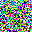

In [108]:
img_np = inverse_transform(result.squeeze())

display(img_np)

### ...

## Inference with pretrained models

In [ ]:
%pip install -q diffusers accelerate

from diffusers import DDPMPipeline

Note: you may need to restart the kernel to use updated packages.


/Users/marco/Dev/_ML/IVU_Tutorials/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
# load model and scheduler
ddpm_cifar10 = DDPMPipeline.from_pretrained("google/ddpm-cifar10-32")
ddpm_cifar10.to(device)

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]An error occurred while trying to fetch /Users/marco/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80: Error no file named diffusion_pytorch_model.safetensors found in directory /Users/marco/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00, 36.34it/s]


DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.33.1",
  "_name_or_path": "google/ddpm-cifar10-32",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

100%|██████████| 1000/1000 [00:33<00:00, 29.97it/s]


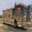

In [38]:
# run pipeline in inference (sample random noise and denoise)
image = ddpm_cifar10().images[0]

display(image)

In [ ]:
# this model is quite big, it might take a while to download

# load model and scheduler
ddpm_celeba = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
ddpm_celeba.to(device)


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]An error occurred while trying to fetch /Users/marco/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /Users/marco/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00, 22.59it/s]


DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.33.1",
  "_name_or_path": "google/ddpm-celebahq-256",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

100%|██████████| 1000/1000 [03:11<00:00,  5.23it/s]


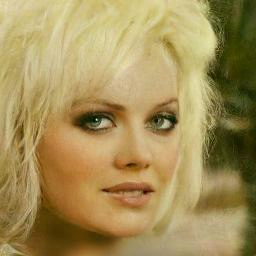

In [ ]:
# this might take several minutes

# run pipeline in inference (sample random noise and denoise)
image = ddpm_celeba().images[0]

display(image)